In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import norm, svds

from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim

from polara.lib.tensor import hooi
from polara.lib.sparse import tensor_outer_at

from dataprep import full_preproccessing
from utils import *
# from RecVAE.utils import *
# from RecVAE.model import VAE as RecVAE

In [3]:
def fix_torch_seed(seed, conv_determinism=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # settings below may affect computational performance
    # see https://pytorch.org/docs/stable/notes/randomness.html:
    if conv_determinism:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def set_random_seed(seed):
#     torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
# fix_torch_seed(42)
set_random_seed(42)

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

# Data preprocessing

In [6]:
data = pd.read_csv('Food_com.csv')
data.rename(columns = {'user_id' : 'userid', 'recipe_id' : 'movieid', "date" : "timestamp"}, inplace = True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [7]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 25076 users
Filtered 24583 invalid observations.


In [ ]:
data.movieid.nunique()

In [10]:
check = pd.concat((training, testset_valid, holdout_valid, testset, holdout))

In [11]:
check.shape[0] / check.userid.nunique() / check.movieid.nunique() * 100

0.08988984884159722

In [12]:
check.shape[0]

225325

In [13]:
check.userid.nunique(), check.movieid.nunique()

(9743, 25728)

In [9]:
del data

# Baselines

## TopPop

In [8]:
def build_popularity_model(trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    n_users = testset_description['n_test_users']
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

## Normalized PureSVD

In [16]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    #print(source_matrix.shape)
    D = norm(source_matrix, axis=0)
    A = source_matrix.dot(diags(D**(config['f']-1)))
    _, _, vt = svds(A, k=config['rank'], return_singular_vectors='vh')
#     singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def svd_model_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    #print(test_matrix.shape, item_factors.shape)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## EASEr

In [32]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def easer(data, data_description, lmbda=500):
    X = matrix_from_observations(data, data_description)
    G = X.T.dot(X)
    diag_indices = np.diag_indices(G.shape[0])
    G[diag_indices] += lmbda
    P = np.linalg.inv(G.A)
    B = P / (-np.diag(P))
    B[diag_indices] = 0
    
    return B

def easer_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    scores = test_matrix.dot(item_factors)
    return scores

## CoFFee

In [8]:
def tf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    idx = data[[userid, itemid, feedback]].values
    idx[:, -1] = idx[:, -1] - data_description['min_rating'] # works only for integer ratings!
    val = np.ones(idx.shape[0], dtype='f8')
    
    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    n_ratings = data_description["n_ratings"]
    shape = (n_users, n_items, n_ratings)
    core_shape = config['mlrank']
    num_iters = config["num_iters"]
    
    u0, u1, u2, g = hooi(
        idx, val, shape, core_shape,
        num_iters=num_iters,
        parallel_ttm=False, growth_tol=0.01,
    )
    return u0, u1, u2
        

def tf_scoring(params, data, data_description):
    user_factors, item_factors, feedback_factors = params
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    data = data.sort_values(userid)
    useridx = data[userid].values
    itemidx = data[itemid].values
    ratings = data[feedback].values
    ratings = ratings - data_description['min_rating'] # works only for integer ratings!
    
    tensor_outer = tensor_outer_at('cpu')
    # use the fact that test data is sorted by users for reduction:
    scores = tensor_outer(
        1.0,
        item_factors,
        feedback_factors,
        itemidx,
        ratings
    )
    scores = np.add.reduceat(scores, np.r_[0, np.where(np.diff(useridx))[0]+1])
    scores = np.tensordot(
        scores,
        feedback_factors[-1, :],
        axes=(2, 0)
    ).dot(item_factors.T)
    return scores

## Simple AE

In [8]:
class MVDataset(Dataset):
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1*self.data.shape[1]))
            idxs = torch.randint(0, self.data.shape[1], size=(num_noise,))
            noised_input = self.data[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,)).to(self.data.device)
            
            useridx = np.zeros_like(noised_input.cpu())
            itemidx = np.arange(self.data.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.data[idx]
        else:
            return self.data[idx], self.data[idx]

In [9]:
class baseAE(nn.Module):
    def __init__(self, n_items, hid):
        super(baseAE, self).__init__()
        self.V = nn.Linear(n_items, hid)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.VT = nn.Linear(hid, n_items)
        torch.nn.init.xavier_uniform_(self.VT.weight)
        self.relu = nn.ReLU()

    def forward(self, x):
        # encode
        x = self.V(x)
        x = self.relu(x)
        # decode
        output = self.VT(x)
#         output = self.relu(output)
        return output

In [10]:
def base_model(h, data_description, device):
    ae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    return ae, criterion, optimizer, scheduler

## RecVAE

In [7]:
vae = RecVAE(600, 200, 1000)
sum(p.numel() for p in vae.parameters() if p.requires_grad)

2490400

# Tuning

## Normalized PureSVD

In [14]:
rank_grid = []
for i in range(5, 10):
    rank_grid.append(2 * 2 ** i)
    rank_grid.append(3 * 2 ** i)
    
rank_grid = np.array(rank_grid)

f_grid = np.linspace(0, 2, 21)

In [ ]:
hr_tf = {}
mrr_tf = {}
c_tf = {}
grid = list(zip(np.meshgrid(rank_grid, f_grid)[0].flatten(), np.meshgrid(rank_grid, f_grid)[1].flatten()))
for params in tqdm(grid):
    r, f = params
    svd_config = {'rank': int(r), 'f': f}
    svd_params = build_svd_model(svd_config, training, data_description)
    svd_scores = svd_model_scoring(svd_params, testset_valid, data_description)
    downvote_seen_items(svd_scores, testset_valid, data_description)
    svd_recs = topn_recommendations(svd_scores, topn=10)
    for alpha in [2,3,4,5]:
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(svd_recs, holdout_valid, data_description, alpha=alpha)
        hr_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = hr
        mrr_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = mrr
        c_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = C

In [ ]:
sorted(c_tf.items(), key=lambda x: x[1], reverse=True)

## EASEr

In [9]:
lambda_grid = np.arange(10, 510, 10)

In [10]:
hr_tf = {}
mrr_tf = {}
c_tf = {}
for lmbda in tqdm(lambda_grid):
    easer_params = easer(training, data_description, lmbda=lmbda)
    easer_scores = easer_scoring(easer_params, testset_valid, data_description)
    downvote_seen_items(easer_scores, testset_valid, data_description)
    easer_recs = topn_recommendations(easer_scores, topn=10)
    for alpha in [2,3,4,5]:
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(easer_recs, holdout_valid, data_description, alpha=alpha)
        hr_tf[f'lambda={lmbda}, alpha={alpha}'] = hr
        mrr_tf[f'lambda={lmbda}, alpha={alpha}'] = mrr
        c_tf[f'lambda={lmbda}, alpha={alpha}'] = C

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
sorted(c_tf.items(), key=lambda x: x[1], reverse=True)

{10: 0.06382978723404255,
 20: 0.06758448060075094,
 30: 0.07108886107634543,
 40: 0.07459324155193993,
 50: 0.07659574468085106,
 60: 0.07909887359198998,
 80: 0.08035043804755945,
 70: 0.08110137672090113,
 90: 0.08110137672090113,
 110: 0.08110137672090113,
 100: 0.08160200250312892,
 120: 0.0818523153942428,
 130: 0.08235294117647059,
 140: 0.08260325406758448,
 150: 0.08310387984981227,
 160: 0.08310387984981227,
 170: 0.08385481852315395,
 180: 0.08485607008760951,
 190: 0.0853566958698373,
 200: 0.08610763454317898,
 210: 0.08660826032540676,
 220: 0.08685857321652066,
 350: 0.08710888610763455,
 360: 0.08710888610763455,
 370: 0.08710888610763455,
 280: 0.08735919899874844,
 290: 0.08735919899874844,
 340: 0.08735919899874844,
 390: 0.08735919899874844,
 260: 0.08760951188986234,
 270: 0.08760951188986234,
 320: 0.08760951188986234,
 330: 0.08760951188986234,
 380: 0.08760951188986234,
 240: 0.08785982478097622,
 250: 0.08785982478097622,
 300: 0.08785982478097622,
 400: 0.0878

## CoFFee

In [13]:
config = {
    "scaling": 1,
    "n_ratings": data_description['n_ratings'],
    "num_iters": 4,
    "params": None,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42
}

grid1 = 2**np.arange(4, 12)
grid2 = np.arange(2, 5)
grid = np.meshgrid(grid1, grid2)

In [12]:
hr_tf = {}
mrr_tf = {}
for r12, r3 in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    config['mlrank'] = (r12, r12, r3)
    tf_params = tf_model_build(config, training, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(tf_recs, holdout_valid, data_description)
    hr_tf[(r12, r3)] = hr
    mrr_tf[(r12, r3)] = mrr

  0%|          | 0/24 [00:00<?, ?it/s]

growth of the core: 1.0
growth of the core: 0.17108376145578136
growth of the core: 0.013724276626127477
growth of the core: 0.002121752668025982
Done
growth of the core: 1.0
growth of the core: 0.1944648491989059
growth of the core: 0.02467704747273349
growth of the core: 0.005981755700370528
Done
growth of the core: 1.0
growth of the core: 0.16282144181882102
growth of the core: 0.029912952116613767
growth of the core: 0.013916498704220537
Done
growth of the core: 1.0
growth of the core: 0.23035313236669488
growth of the core: 0.034784826568450604
growth of the core: 0.011006067169166954
Done
growth of the core: 1.0
growth of the core: 0.17594728189169354
growth of the core: 0.030919135038606764
growth of the core: 0.008959802437981649
Done
growth of the core: 1.0
growth of the core: 0.1619910003475919
growth of the core: 0.025820893734533307
growth of the core: 0.008684790230411127
Done
growth of the core: 1.0
growth of the core: 0.19297251628357556
growth of the core: 0.01668695007

In [13]:
hr_tf

{(16, 2): 0.05102639296187683,
 (32, 2): 0.05689149560117302,
 (64, 2): 0.06099706744868035,
 (128, 2): 0.05337243401759531,
 (256, 2): 0.06862170087976541,
 (512, 2): 0.031085043988269796,
 (1024, 2): 0.021114369501466276,
 (2048, 2): 0.008211143695014663,
 (16, 3): 0.04868035190615835,
 (32, 3): 0.04574780058651026,
 (64, 3): 0.052785923753665684,
 (128, 3): 0.047507331378299114,
 (256, 3): 0.04105571847507332,
 (512, 3): 0.03284457478005865,
 (1024, 3): 0.01818181818181818,
 (2048, 3): 0.004105571847507331,
 (16, 4): 0.04281524926686217,
 (32, 4): 0.04574780058651026,
 (64, 4): 0.04926686217008798,
 (128, 4): 0.0469208211143695,
 (256, 4): 0.0404692082111437,
 (512, 4): 0.03167155425219941,
 (1024, 4): 0.01935483870967742,
 (2048, 4): 0.004105571847507331}

## Simple AE

In [11]:
grid = 2**np.arange(4, 11)

  0%|          | 0/7 [00:00<?, ?it/s]

Hidden sizes: 16
Current epoch 58
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016512,0.008365,0.000738,0.010378,0.014703,0.00181,0.007728,0.000637,0.009452,0.000927,-0.014472


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.0285,0.009882,0.001088,0.014173,0.026238,0.002262,0.009192,0.000691,0.013107,0.001066,0.000018


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.051572,0.011463,0.001982,0.019981,0.046143,0.005429,0.010552,0.00091,0.018113,0.001867,-0.022313


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016286,0.008064,0.001244,0.010098,0.013572,0.002714,0.006974,0.001089,0.008606,0.001492,-0.030788


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.009863,0.002177,0.014562,0.026691,0.003619,0.008646,0.001217,0.01277,0.001792,-0.013957


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.052703,0.011372,0.003692,0.020165,0.044786,0.007917,0.009857,0.001515,0.017289,0.002876,-0.043276


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016286,0.008064,0.001244,0.010098,0.012893,0.003393,0.006447,0.001617,0.008041,0.002058,-0.02897


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.009863,0.002177,0.014562,0.025334,0.004976,0.008031,0.001832,0.011988,0.002573,-0.016752


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.052703,0.011372,0.003692,0.020165,0.042298,0.010405,0.009161,0.002211,0.016218,0.003947,-0.045509


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.017417,0.008086,0.001205,0.010376,0.012667,0.00475,0.005745,0.002341,0.007439,0.002937,-0.003408


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.029857,0.009723,0.00206,0.014376,0.023072,0.006786,0.007122,0.002601,0.010792,0.003584,0.013656


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.051572,0.011204,0.003692,0.019833,0.037548,0.014024,0.008088,0.003116,0.014403,0.00543,-0.005546


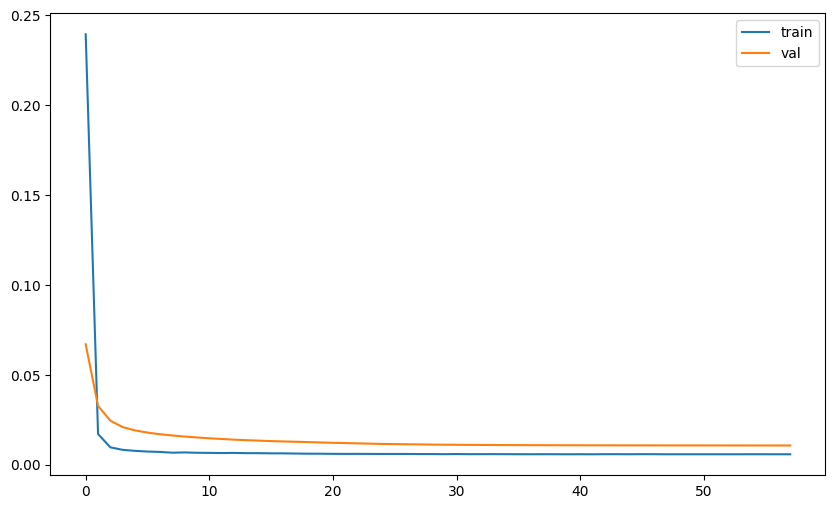

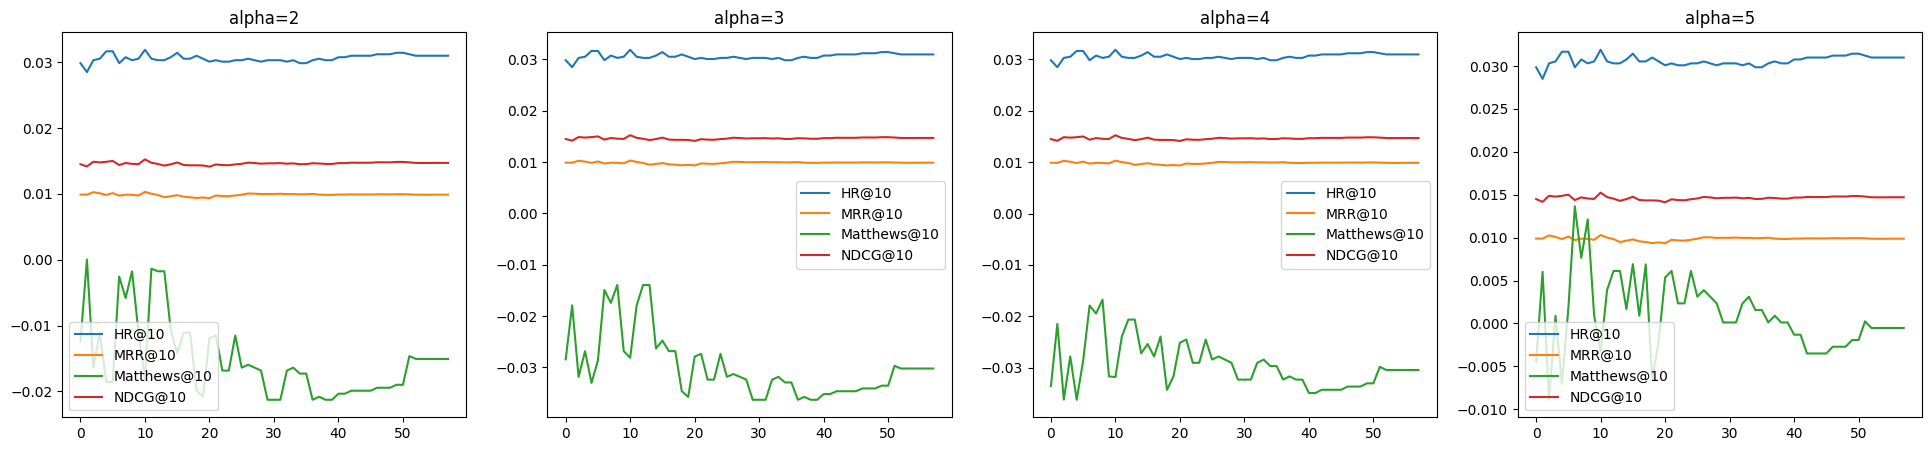

Test loss: 0.015665870159864426
Train loss: 0.006838755067662002


Hidden sizes: 32
Current epoch 75
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016738,0.008516,0.001555,0.010555,0.015155,0.001583,0.007868,0.000648,0.009676,0.000879,-0.007336


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.010184,0.002604,0.014799,0.028048,0.002262,0.009438,0.000746,0.013693,0.001106,0.003117


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050893,0.011567,0.004664,0.019946,0.045012,0.005881,0.010579,0.000988,0.017938,0.002009,-0.030974


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016738,0.008516,0.001555,0.010555,0.014024,0.002714,0.007151,0.001365,0.008854,0.0017,-0.029226


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.010184,0.002604,0.014799,0.026691,0.003619,0.008689,0.001495,0.012796,0.002002,-0.013957


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050893,0.011567,0.004664,0.019946,0.043203,0.007691,0.009796,0.00177,0.016923,0.003023,-0.04319


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016738,0.008516,0.001555,0.010555,0.013119,0.003619,0.006842,0.001674,0.008398,0.002157,-0.032414


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.010184,0.002604,0.014799,0.025334,0.004976,0.008332,0.001852,0.012207,0.002592,-0.016752


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050893,0.011567,0.004664,0.019946,0.040489,0.010405,0.009348,0.002219,0.015993,0.003953,-0.049478


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016738,0.008516,0.001555,0.010555,0.011988,0.00475,0.00622,0.002296,0.007646,0.002909,-0.006622


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.010184,0.002604,0.014799,0.023524,0.006786,0.007621,0.002564,0.011236,0.003563,0.015127


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050893,0.011567,0.004664,0.019946,0.036191,0.014703,0.008457,0.00311,0.014386,0.005561,-0.014444


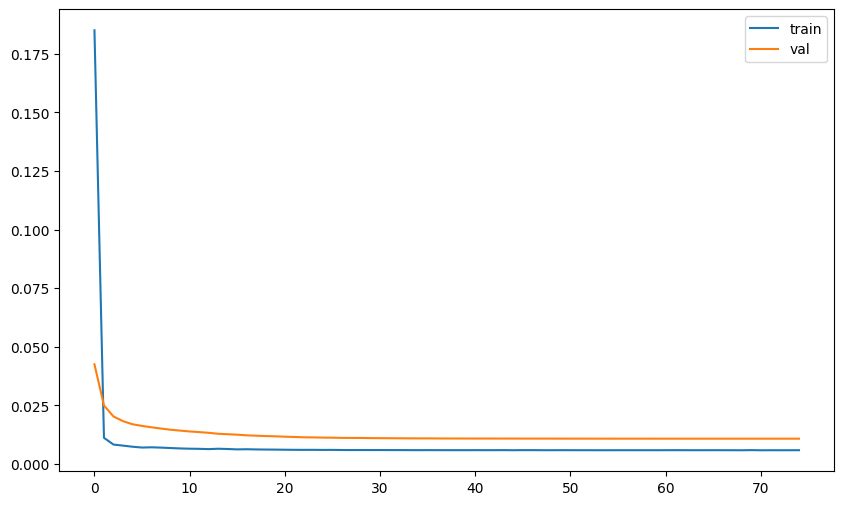

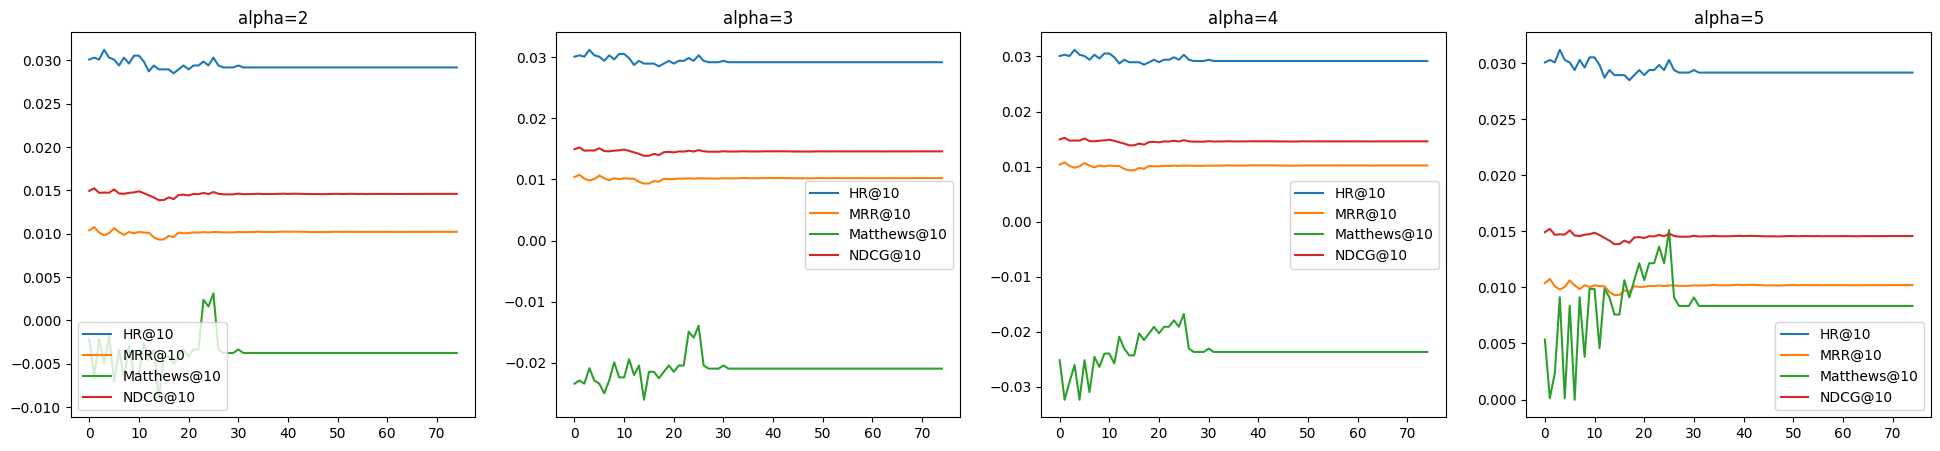

Test loss: 0.011201896704733372
Train loss: 0.005997460977956255


Hidden sizes: 64
Current epoch 86
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.017643,0.009391,0.000738,0.011414,0.01606,0.001583,0.008271,0.00112,0.010182,0.001232,-0.00513


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.029405,0.010909,0.001205,0.015165,0.027143,0.002262,0.009691,0.001218,0.013706,0.00146,0.001591


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.052477,0.012478,0.00206,0.020957,0.046596,0.005881,0.011009,0.001468,0.018583,0.002374,-0.028443


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016964,0.008576,0.001671,0.010658,0.013798,0.003167,0.006922,0.001655,0.008624,0.002033,-0.040347


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.030536,0.010318,0.002799,0.014975,0.026691,0.003845,0.008587,0.001731,0.012737,0.002238,-0.017938


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050667,0.011662,0.004664,0.019998,0.043429,0.007238,0.009699,0.001963,0.016906,0.003092,-0.03662


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016964,0.008576,0.001671,0.010658,0.012893,0.004071,0.006601,0.001975,0.008158,0.0025,-0.041864


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.030536,0.010318,0.002799,0.014975,0.025334,0.005202,0.008202,0.002116,0.01212,0.002855,-0.020061


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050667,0.011662,0.004664,0.019998,0.040715,0.009952,0.009222,0.002439,0.015949,0.004049,-0.043893


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016964,0.008576,0.001671,0.010658,0.011762,0.005202,0.005979,0.002597,0.007406,0.003252,-0.013508


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.030536,0.010318,0.002799,0.014975,0.023524,0.007012,0.007489,0.002829,0.011148,0.003827,0.012863


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050667,0.011662,0.004664,0.019998,0.036417,0.01425,0.008331,0.003331,0.014341,0.005657,-0.010394


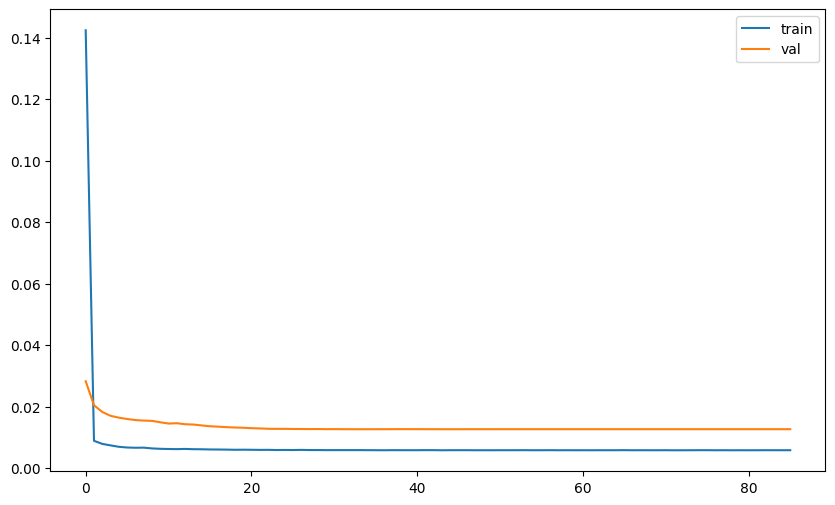

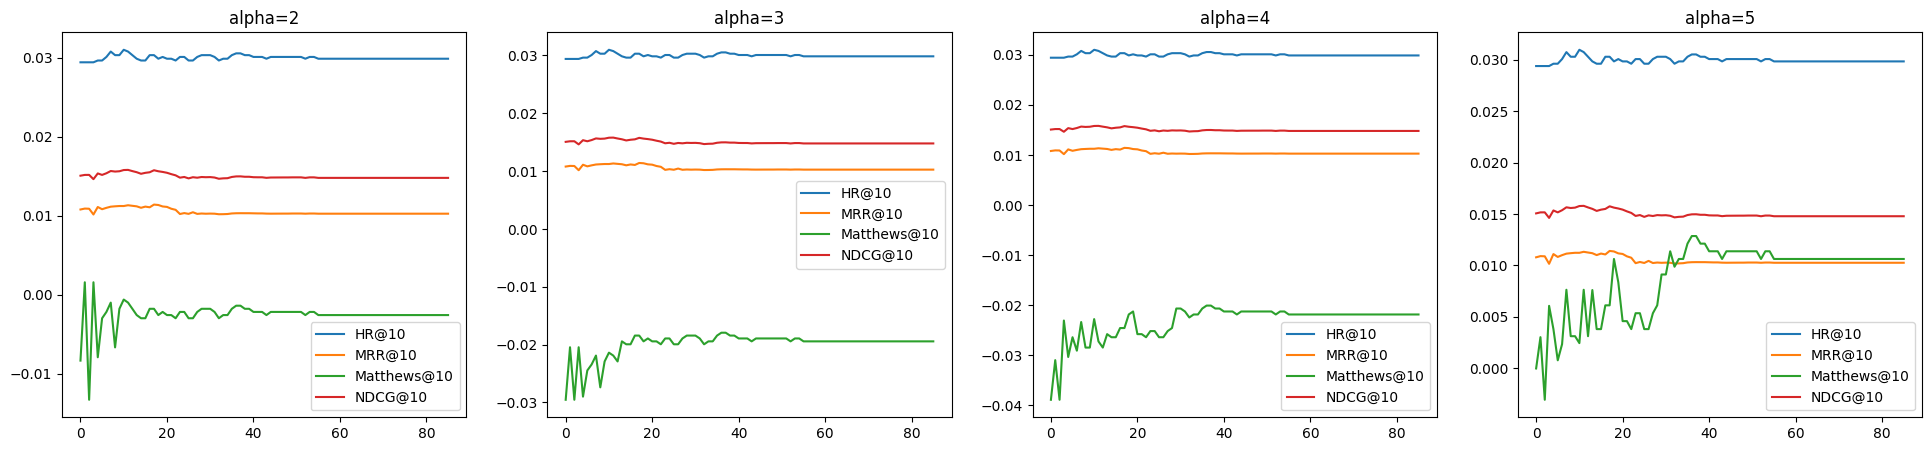

Test loss: 0.012669938616454601
Train loss: 0.005834124345496735


Hidden sizes: 128
Current epoch 79
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.017191,0.009368,0.00171,0.011296,0.015381,0.00181,0.008203,0.001165,0.009976,0.00132,-0.012655


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.028727,0.010911,0.002954,0.015031,0.026465,0.002262,0.009681,0.00123,0.013561,0.001471,0.000416


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.052929,0.012521,0.005014,0.021064,0.047048,0.005881,0.011056,0.001465,0.018699,0.002366,-0.027735


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016286,0.008584,0.00171,0.010504,0.013572,0.002714,0.007031,0.001553,0.008656,0.001849,-0.030788


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.010396,0.002954,0.01498,0.026465,0.003845,0.008693,0.001704,0.012766,0.002214,-0.018433


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050893,0.011789,0.005053,0.020141,0.043655,0.007238,0.009851,0.001938,0.017069,0.003072,-0.036207


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016286,0.008584,0.00171,0.010504,0.012893,0.003393,0.006767,0.001817,0.008287,0.002217,-0.02897


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.010396,0.002954,0.01498,0.025107,0.005202,0.008321,0.002075,0.012161,0.00282,-0.020648


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050893,0.011789,0.005053,0.020141,0.040941,0.009952,0.009387,0.002402,0.016122,0.004018,-0.043399


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016286,0.008595,0.001788,0.010514,0.011762,0.004524,0.006156,0.002439,0.007545,0.002969,-0.004772


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.03031,0.010358,0.003032,0.014941,0.023298,0.007012,0.007596,0.002762,0.011176,0.003766,0.012124


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050667,0.011726,0.005169,0.020032,0.036417,0.01425,0.008459,0.003266,0.014434,0.005598,-0.010394


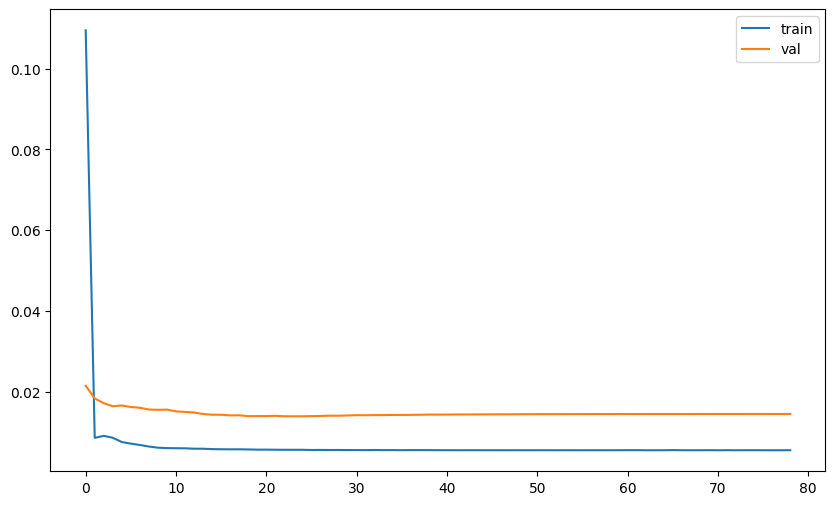

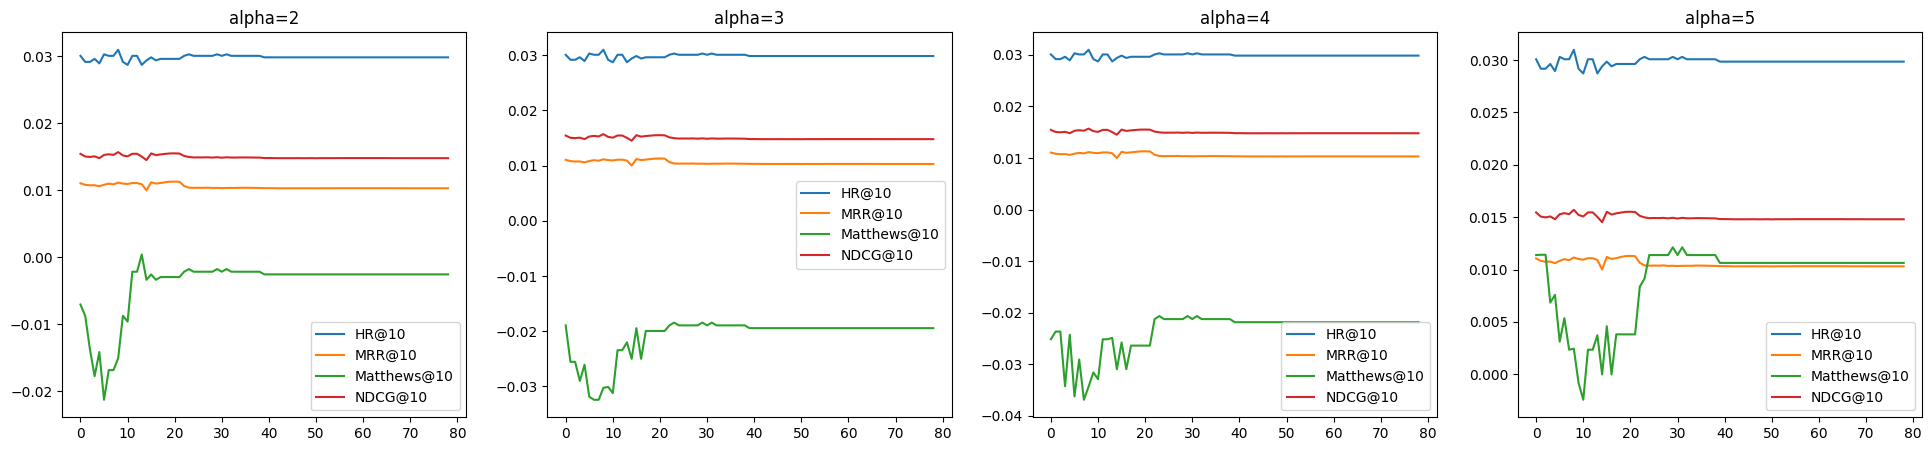

Test loss: 0.014062605798244476
Train loss: 0.005484469097984188


Hidden sizes: 256
Current epoch 112
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.018095,0.009583,0.001788,0.011676,0.016286,0.00181,0.008633,0.00095,0.010513,0.001163,-0.010347


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.029405,0.011078,0.002915,0.01532,0.027143,0.002262,0.010058,0.00102,0.014001,0.001319,0.001591


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.052477,0.012598,0.004897,0.021054,0.046822,0.005655,0.011349,0.00125,0.018884,0.00217,-0.024691


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.016512,0.008969,0.001011,0.010815,0.014703,0.00181,0.00751,0.001459,0.009273,0.001542,-0.005915


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.029857,0.010664,0.001827,0.015046,0.026012,0.003845,0.008931,0.001733,0.012843,0.002203,-0.019435


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.052477,0.012216,0.002993,0.020745,0.045239,0.007238,0.010246,0.00197,0.017682,0.003063,-0.033371


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.017417,0.00892,0.001671,0.011032,0.013572,0.003845,0.006944,0.001975,0.008585,0.002448,-0.03487


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.029857,0.010484,0.003148,0.014958,0.024655,0.005202,0.008338,0.002146,0.012082,0.002876,-0.021836


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.050667,0.011879,0.005286,0.020158,0.040715,0.009952,0.009412,0.002467,0.016091,0.004067,-0.043893


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.015381,0.008663,0.001049,0.010319,0.011536,0.003845,0.005666,0.002997,0.007109,0.00321,0.003265


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.0285,0.010336,0.001477,0.014483,0.021941,0.00656,0.00699,0.003345,0.010409,0.004074,0.012208


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.054739,0.012075,0.00276,0.021012,0.041167,0.013572,0.008251,0.003824,0.015176,0.005837,0.007418


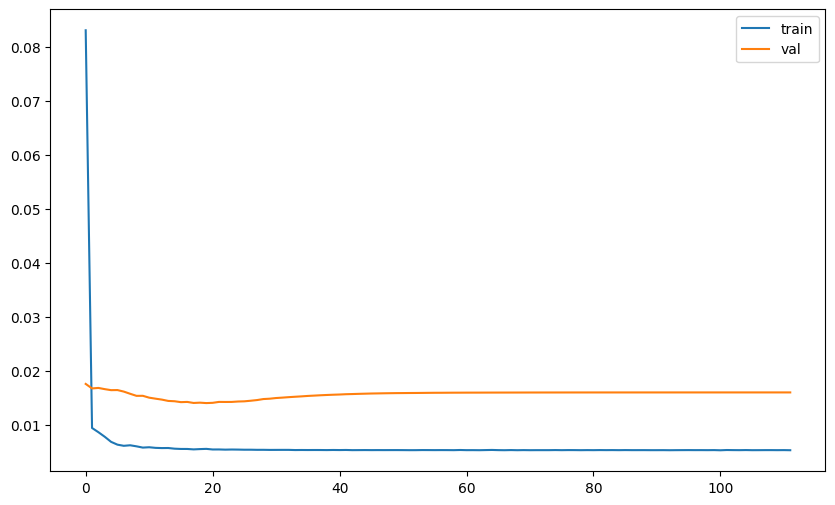

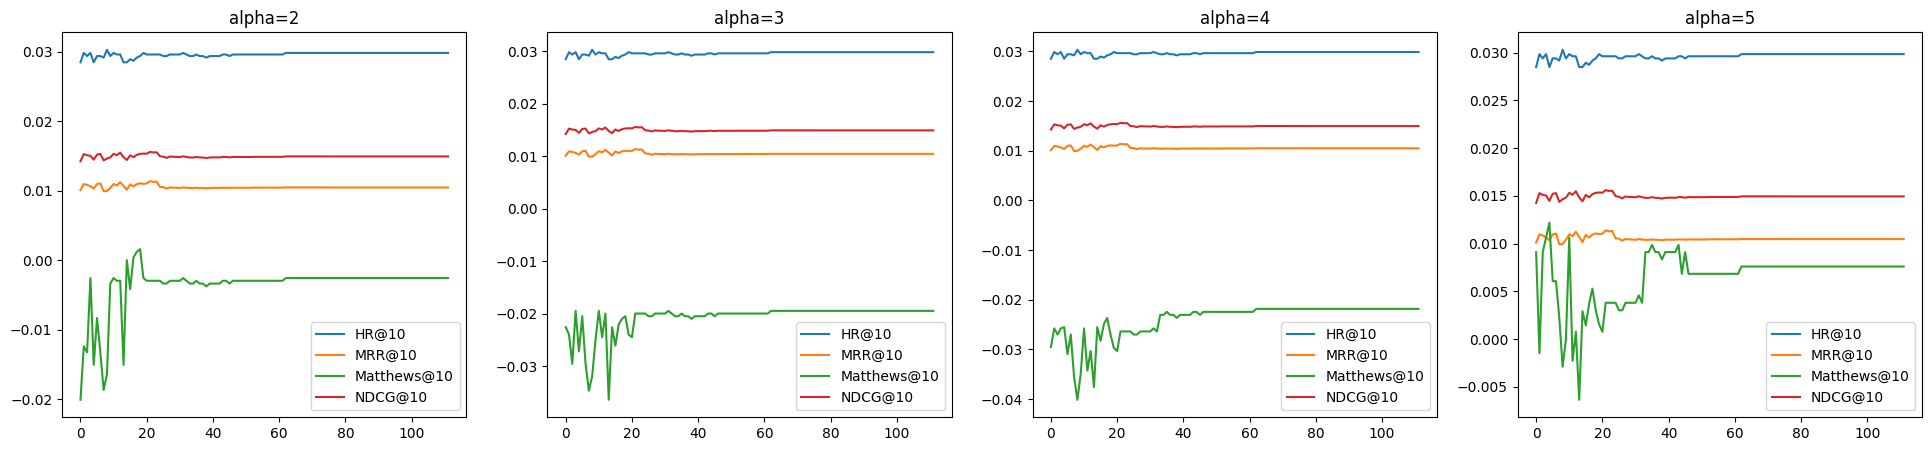

Test loss: 0.01598522812128067
Train loss: 0.005322875394012759


Hidden sizes: 512


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\caffe2\serialize\inline_container.cc:337] . unexpected pos 52693952 vs 52693840

In [12]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, base_model, device, grid, batch_size=batch_size)

In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    tuning_pipeline_augment(training, testset_valid, holdout_valid, data_description, base_model, grid, device, MVDataset, batch_size=batch_size)

## VAE

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [97]:
alpha = 3

# training
vae_training = training[training['rating']>=alpha]
n_users = vae_training['userid'].max()+1
n_items = data_description['n_items']

rows, cols = vae_training['userid'], vae_training['movieid']
vae_train_data = sparse.csr_matrix((np.ones_like(rows),
                         (rows, cols)), dtype='float64',
                         shape=(n_users, n_items))

# validation
start_idx = min(testset_valid['userid'].min(), holdout_valid['userid'].min())
end_idx = max(testset_valid['userid'].max(), holdout_valid['userid'].max())

rows_tr, cols_tr = testset_valid['userid'] - start_idx, testset_valid['movieid']
rows_te, cols_te = holdout_valid['userid'] - start_idx, holdout_valid['movieid']

valid_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
valid_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

# test
start_idx = min(testset['userid'].min(), holdout['userid'].min())
end_idx = max(testset['userid'].max(), holdout['userid'].max())

rows_tr, cols_tr = testset['userid'] - start_idx, testset['movieid']
rows_te, cols_te = holdout['userid'] - start_idx, holdout['movieid']

test_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
test_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

In [105]:
np.sum(vae_train_data.A), np.sum(valid_in_data.A), np.sum(valid_out_data.A), np.sum(test_in_data.A), np.sum(test_out_data.A)

(462784.0, 196310.0, 1705.0, 198048.0, 1738.0)

In [129]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)


class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)


def evaluate(model, data_in, data_out, metrics, samples_perc_per_epoch=1, batch_size=500):
    metrics = deepcopy(metrics)
    model.eval()
    
    for m in metrics:
        m['score'] = []
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        ratings_in = batch.get_ratings_to_dev()
#         print(ratings_in)
        ratings_out = batch.get_ratings(is_out=True)
#         print(ratings_out)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
#         print(ratings_pred)
        
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        for m in metrics:
            m['score'].append(m['metric'](ratings_pred, ratings_out, k=m['k']))

    for m in metrics:
        m['score'] = np.concatenate(m['score']).mean()
        
    return [x['score'] for x in metrics]


def run(model, opts, train_data, batch_size, n_epochs, beta, gamma, dropout_rate):
    model.train()
    for epoch in range(n_epochs):
        for batch in generate(batch_size=batch_size, device=device, data_in=train_data, shuffle=True):
            ratings = batch.get_ratings_to_dev()
#             print(ratings)

            for optimizer in opts:
                optimizer.zero_grad()
                
            a, loss = model(ratings, beta=beta, gamma=gamma, dropout_rate=dropout_rate)
            print(a, loss)
#             print(loss)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()

In [130]:
grid1 = np.arange(100, 2100, 100)
grid = np.meshgrid(grid1, grid1)

In [131]:
model_kwargs = {
    'hidden_dim': 100,
    'latent_dim': 100,
    'input_dim': vae_train_data.shape[1]
}
metrics = [{'metric': ndcg, 'k': 10}]

best_ndcg = -np.inf
train_scores, valid_scores = [], []

model = RecVAE(**model_kwargs).to(device)
model_best = RecVAE(**model_kwargs).to(device)

learning_kwargs = {
    'model': model,
    'train_data': vae_train_data,
    'batch_size': 512,
    'beta': None,
    'gamma': 0.005
}

decoder_params = set(model.decoder.parameters())
encoder_params = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_params, lr=5e-4)
optimizer_decoder = optim.Adam(decoder_params, lr=5e-4)

n_epochs = 50

for epoch in range(n_epochs):

    run(opts=[optimizer_encoder], n_epochs=3, dropout_rate=0.5, **learning_kwargs)
    model.update_prior()
    run(opts=[optimizer_decoder], n_epochs=1, dropout_rate=0, **learning_kwargs)

    train_scores.append(
        evaluate(model, vae_train_data, vae_train_data, metrics, 0.01)[0]
    )
    valid_scores.append(
        evaluate(model, valid_in_data, valid_out_data, metrics, 1)[0]
    )
    
    if valid_scores[-1] > best_ndcg:
        best_ndcg = valid_scores[-1]
        model_best.load_state_dict(deepcopy(model.state_dict()))
        

    print(f'epoch {epoch} | valid ndcg@100: {valid_scores[-1]:.4f} | ' +
          f'best valid: {best_ndcg:.4f} | train ndcg@100: {train_scores[-1]:.4f}')


    
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, dev

C:\Users\Liza\Desktop\Thesis\RecVAE\utils.py:98: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


epoch 0 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.0184
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward

KeyboardInterrupt: 

In [106]:
valid_scores

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []


for h1, h2, in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    print('Hidden sizes:', h1, h2)
    
    vae = VAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters(), lr=5*1e-4)
    
    mask = torch.triu(torch.ones_like(ae.L.weight))
    # Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    n_epochs = 20
    history = []
    prev_train_loss = 1
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1

    while prev_train_loss - train_loss / len(train_dataloader) > 1e-4 or train_loss / len(train_dataloader) > 1e-2:
        if epoch > 1:
            prev_train_loss = train_loss / len(train_dataloader)
        
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        history.append(train_loss / len(train_dataloader))
        epoch += 1
        
        if epoch > 50:
            break
    
    histories.append(history)
    
#         print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
    
    # Testing the AE
    test_loss = 0

    for user in testset_valid.userid.unique():
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())

#     print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)

        output = ae(user_matrix_test)
        scores[i] = output[0].T


    scores = scores.detach().numpy()
    
    # our
    plt.plot(history)
    plt.show()
    print('Test loss:', test_loss / testset_valid.userid.nunique())
    print('Epochs:', epoch)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

# Test metrics

In [9]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_ratings = training['rating'].nunique(),
    min_rating = training['rating'].min(),
    test_users = holdout[data_index['users'].name].drop_duplicates().values,
    n_test_users = holdout[data_index['users'].name].nunique()
)

In [10]:
train_val = pd.concat((training, testset_valid, holdout_valid))

## TopPop

In [11]:
pop_params = build_popularity_model(train_val, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
downvote_seen_items(pop_scores, testset, data_description)

make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=2)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=3)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=4)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=5)

,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.01903,0.008176,0.000661,0.010824,0.017932,0.001098,0.007798,0.000378,0.010268,0.000555,0.012809


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.02946,0.009526,0.001127,0.014154,0.027447,0.002013,0.009029,0.000496,0.013307,0.000847,0.009312


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.046661,0.010688,0.001905,0.018462,0.042635,0.004026,0.010053,0.000634,0.017108,0.001354,-0.002565


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.01903,0.008176,0.000661,0.010824,0.017566,0.001464,0.007524,0.000653,0.00997,0.000854,0.01037


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.02946,0.009526,0.001127,0.014154,0.026898,0.002562,0.008735,0.000791,0.012954,0.001201,0.007123


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.046661,0.010688,0.001905,0.018462,0.04172,0.004941,0.009737,0.00095,0.016668,0.001795,-0.004963


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.01903,0.008176,0.000661,0.010824,0.017383,0.001647,0.007432,0.000744,0.009854,0.000969,0.018811


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.02946,0.009526,0.001127,0.014154,0.026167,0.003294,0.008568,0.000958,0.012659,0.001495,0.010539


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.046661,0.010688,0.001905,0.018462,0.040439,0.006221,0.009535,0.001152,0.016237,0.002225,-0.000677


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.01903,0.008176,0.000661,0.010824,0.015371,0.00366,0.006398,0.001778,0.00858,0.002244,0.018706


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.02946,0.009526,0.001127,0.014154,0.023056,0.006404,0.007388,0.002137,0.01103,0.003124,0.013314


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.046661,0.010688,0.001905,0.018462,0.035499,0.011162,0.008233,0.002454,0.014152,0.00431,0.005763


(0.009525770051845076,
 0.029460201280878315,
 0.01331385191430801,
 0.01415444725153221)

## Normalized PureSVD

In [ ]:
svd_params = build_svd_model({'rank':1536, 'f':0.4}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=2)

svd_params = build_svd_model({'rank':1536, 'f':0.4}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=3)

svd_params = build_svd_model({'rank':64, 'f':1.0}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=4)

svd_params = build_svd_model({'rank':96, 'f':0.7}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=5)

## EASEr

In [33]:
easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=2)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=3)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=4)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=5)

,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.070086,0.040917,0.507672,0.048153,0.066618,0.003468,0.038943,0.001974,0.045812,0.002341,0.045204


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.099653,0.044846,0.680699,0.057699,0.094543,0.00511,0.042643,0.002203,0.054817,0.002882,0.052768


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.134879,0.047187,0.830709,0.066476,0.127396,0.007483,0.044825,0.002362,0.063001,0.003475,0.057065


(0.04484641213058808,
 0.09965322139076474,
 0.052767573990321705,
 0.057699332516444615)

## CoFFee

In [ ]:
config['mlrank'] = (256, 256, 2)
tf_params = tf_model_build(config, train_val, data_description)
seen_data = testset
tf_scores = tf_scoring(tf_params, seen_data, data_description)
downvote_seen_items(tf_scores, seen_data, data_description)

make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=2)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=3)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=4)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=5)

## Simple AE


In [51]:
h = ...
batch_size = ...
training_testing_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, base_model, h, device, batch_size=batch_size)
# training_testing_pipeline_augment(training, testset_valid, holdout_valid, testset, holdout, data_description, model_init, h, device, MVDataset, batch_size=batch_size)

KeyboardInterrupt: 